###**Import Libraries**

In [1]:
# Import libraries
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import time
import tensorflow as tf
from tensorflow.keras import layers
from IPython import display

###**Load Data**

In [2]:
# Load CIFAR Dataset
(train_images, train_labels), (_, _) = tf.keras.datasets.cifar10.load_data()

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 6s 0us/step


In [3]:
train_images.shape

(50000, 32, 32, 3)

In [4]:
train_images[0].max()

255

In [5]:
train_labels[1][0]

9

###**Visualize the dataset**

In [6]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

In [7]:
def plot_images(images, label, class_names):
  plt.figure(figsize = (10, 10))
  for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(images[i])
    plt.xlabel(class_names[label[i][0]])
  plt.show()

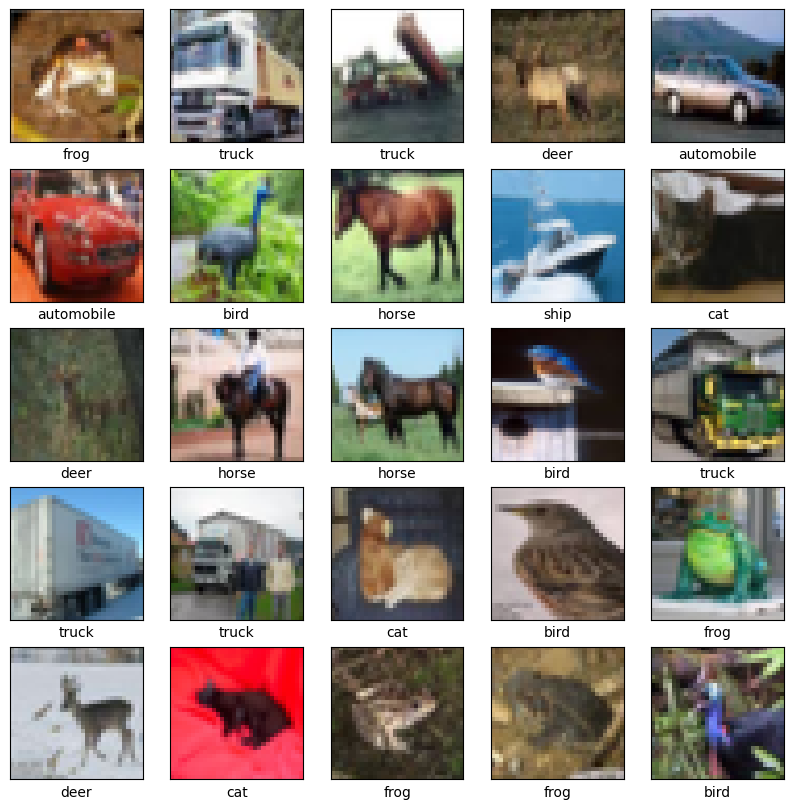

In [8]:
plot_images(train_images, train_labels, class_names)

###**Pre-processing**

In [9]:
# Normalize the images
train_images = train_images.astype('float32')
train_images = (train_images - 127.5) / 127.5 # Normalize to [-1, 1]
print(train_images.shape)

(50000, 32, 32, 3)


In [10]:
train_images[0].min(), train_images[0].max()

(-1.0, 1.0)

In [11]:
IMG_DIM = train_images.shape[1]
IMG_DIM

32

In [12]:
# Define buffer size and batch size
BUFFER_SIZE = 60000
BATCH_SIZE = 256

In [13]:
# Create batches of training data and shuffle
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

##**Generator Model**

In [14]:
# Function to build the generator model for 3-channel (RGB) images
def make_generator_model():
    model = tf.keras.Sequential()

    # Input layer: explicitly define input shape
    model.add(layers.Input(shape=(100,)))  # 100 is the noise dimension

    # First layer: Dense layer to project the input noise vector (latent space) to a higher-dimensional space
    model.add(layers.Dense(8 * 8 * 256, use_bias=False))
    # Batch normalization helps stabilize training by normalizing the outputs of the previous layer
    model.add(layers.BatchNormalization())
    # LeakyReLU activation to allow a small gradient when the unit is not active
    model.add(layers.LeakyReLU())

    # Reshape the output to a 8x8x256 tensor
    model.add(layers.Reshape((8, 8, 256)))
    # The output shape is (batch_size, 7, 7, 256)

    # First transposed convolutional layer
    # Upsamples the input to a larger feature map
    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    # Output shape: (batch_size, 8, 8, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Second transposed convolutional layer
    # Upsamples to 14x14
    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    # Output shape: (batch_size, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Final transposed convolutional layer
    # Upsamples to 32x32, matches the image size, and outputs 3 channels for RGB
    model.add(layers.Conv2DTranspose(3, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    # Output shape: (batch_size, 32, 32, 3)

    return model

# Instantiate the generator model
generator = make_generator_model()
generator.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 16384)               │       1,638,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 16384)               │          65,536 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu (LeakyReLU)              │ (None, 16384)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 8, 8, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose (Conv2DTranspose)   │ (None, 8, 8, 128)           │         819,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 8, 8, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_1 (LeakyReLU)            │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_1 (Conv2DTranspose) │ (None, 16, 16, 64)          │         204,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 16, 16, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_2 (LeakyReLU)            │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_2 (Conv2DTranspose) │ (None, 32, 32, 3)           │           4,800 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,733,504 (10.43 MB)

 Trainable params: 2,700,352 (10.30 MB)

 Non-trainable params: 33,152 (129.50 KB)

(1, 32, 32, 3)


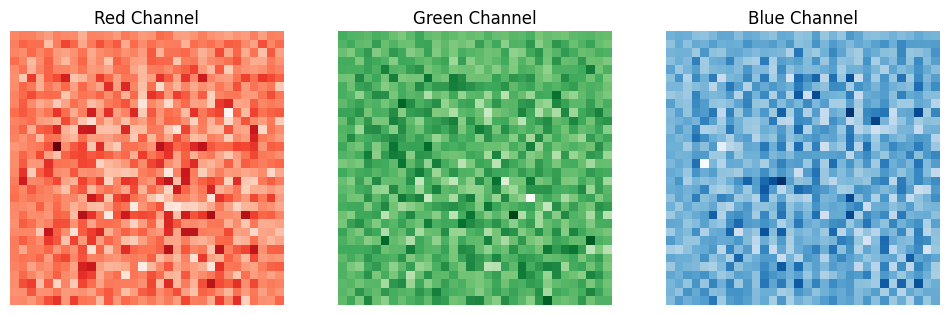

In [15]:
# Generate a sample image from the generator
noise = tf.random.normal([1, 100])  # Generate random noise vector
generated_image = generator(noise, training=False)  # Generate image from noise

# Print the shape of the generated image
print(generated_image.shape)  # Should be (1, 28, 28, 3) for RGB

# Extract individual channels
red_channel = generated_image[0, :, :, 0]
green_channel = generated_image[0, :, :, 1]
blue_channel = generated_image[0, :, :, 2]

# Create a figure to display the channels
plt.figure(figsize=(12, 4))

# Display the red channel
plt.subplot(1, 3, 1)
plt.imshow(red_channel, cmap='Reds')  # Displaying red channel
plt.title("Red Channel")
plt.axis('off')

# Display the green channel
plt.subplot(1, 3, 2)
plt.imshow(green_channel, cmap='Greens')  # Displaying green channel
plt.title("Green Channel")
plt.axis('off')

# Display the blue channel
plt.subplot(1, 3, 3)
plt.imshow(blue_channel, cmap='Blues')  # Displaying blue channel
plt.title("Blue Channel")
plt.axis('off')

# Show the figure
plt.show()

##**Discriminator Model**

In [16]:
# Function to build the discriminator model for RGB images
def make_discriminator_model():
    model = tf.keras.Sequential()

    # Input layer
    model.add(layers.Input(shape=[32, 32, 3]))  # Use InputLayer to explicitly define the input shape

    # First convolutional layer
    # Adjust the input shape to (32, 32, 3) for RGB images
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Second convolutional layer
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Flatten the output and add a final dense layer for classification
    model.add(layers.Flatten())
    model.add(layers.Dense(1))  # Output layer with logits for real/fake classification

    return model

# Instantiate the discriminator model for RGB images
discriminator = make_discriminator_model()
discriminator.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 16, 16, 64)          │           4,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_3 (LeakyReLU)            │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 8, 8, 128)           │         204,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_4 (LeakyReLU)            │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 8192)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │           8,193 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 217,985 (851.50 KB)

 Trainable params: 217,985 (851.50 KB)

 Non-trainable params: 0 (0.00 B)

###**Pass Generated image to Discriminator**

In [17]:
# Test the discriminator on the generated image
decision = discriminator(generated_image)
print("Discriminator output: ", decision)

Discriminator output:  tf.Tensor([[-0.00011796]], shape=(1, 1), dtype=float32)


In [18]:
# Define the loss function
# Binary crossentropy loss is used since we have a binary classification problem (real or fake)
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

###**Discriminator Loss**

In [19]:
def discriminator_loss(real_output, fake_output):
  # Compute loss on real images (should be classified as 1)
  real_loss = cross_entropy(tf.ones_like(real_output), real_output)
  # Compute loss on fake images (should be classified as 0)
  fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
  # Total discriminator loss
  total_loss = real_loss + fake_loss
  return total_loss

###**Generator Loss**

In [20]:
def generator_loss(fake_output):
  # Generator tries to fool the discriminator, so we want the fake images to be classified as real (1)
  return cross_entropy(tf.ones_like(fake_output), fake_output) # Classifying 1

###**Optimizers**

In [21]:
# Define optimizers for both generator and discriminator
# Adam optimizer is commonly used for its adaptive learning rate and momentum
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [22]:
# Set up checkpointing to save the models during training
checkpoint_dir = "./training_checkpoints" # Directory to save checkpoints
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')

# Ensure the checkpoint directory exists
if not os.path.exists(checkpoint_dir):
  os.makedirs(checkpoint_dir)

# Create a checkpoint object to manage all the objects to be saved
checkpoint = tf.train.Checkpoint(generator_optimizer = generator_optimizer,
                                 discriminator_optimizer = discriminator_optimizer,
                                 generator = generator,
                                 discriminator = discriminator)

In [23]:
# Set training parameters
EPOCHS = 100               # Number of epochs to train
noise_dim = 100           # Dimension of the noise vector (latent space)
num_examples_to_generate = 16  # Number of examples to generate for visualization

# Seed for generating images to visualize progress
# Using the same seed allows us to see how the generated images evolve over time
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [24]:
noise = tf.random.normal([BATCH_SIZE, noise_dim])
noise, noise.shape

(<tf.Tensor: shape=(256, 100), dtype=float32, numpy=
 array([[-0.8508172 , -0.89208406, -0.3273869 , ...,  1.3056347 ,
         -0.18709083,  0.6742539 ],
        [ 0.7822698 , -1.3710451 ,  0.6910714 , ..., -0.2800445 ,
         -0.03218714,  0.25936362],
        [ 0.35249007,  0.461654  , -0.16708846, ...,  1.3878597 ,
          1.002179  ,  1.2959409 ],
        ...,
        [-1.1578869 ,  0.4673578 ,  0.36351645, ..., -0.0243823 ,
          0.21336533, -0.9829412 ],
        [-0.22028007,  0.43913737, -1.0126225 , ..., -0.99792236,
          1.0489081 , -0.6596088 ],
        [ 0.45000666, -0.6688601 , -0.41315886, ...,  1.5235093 ,
         -0.6863184 , -0.3533024 ]], dtype=float32)>,
 TensorShape([256, 100]))

In [25]:
generated_images = generator(noise, training = True)
generated_images.shape

TensorShape([256, 32, 32, 3])

###**Training Steps**

In [26]:
# Define the training step function
# Use @tf.function to compile the function for faster execution
@tf.function
def train_step(images):
    # Generate random noise for input to the generator
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    # Record operations for automatic differentiation
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        # Generate fake images from the noise
        generated_images = generator(noise, training=True)

        # Get the discriminator's predictions on real and fake images
        real_output = discriminator(images, training=True)
        # fake_output contains the discriminator's predictions on the fake images.
        fake_output = discriminator(generated_images, training=True)

        #   Explanation:
        '''generator_loss is a function that computes the loss for the generator.
            It takes fake_output as input, which are the discriminator's predictions on fake images.
            gen_loss is the calculated loss value for the generator.
            Purpose:
            The generator wants to fool the discriminator.
            The loss measures how well the generator is doing in making the discriminator believe the fake images are real.
            '''

        # Calculate losses for both generator and discriminator
        gen_loss = generator_loss(fake_output)

        '''
        Explanation:
        discriminator_loss is a function that computes the loss for the discriminator.
        It takes two inputs:
        real_output: Discriminator's predictions on real images.
        fake_output: Discriminator's predictions on fake images.
        disc_loss is the calculated loss value for the discriminator.
        Purpose:
        The discriminator aims to correctly classify real and fake images.
        The loss measures how well the discriminator distinguishes between real and fake data.
        '''
        disc_loss = discriminator_loss(real_output, fake_output)

    # Calculate gradients for generator and discriminator
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    # Apply gradients to update the weights of generator and discriminator
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [27]:

# Function to generate and save images during training
def generate_and_save_images(model, epoch, test_input):
    # Note: Set training=False to ensure that all layers run in inference mode (e.g., dropout and batchnorm)
    predictions = model(test_input, training=False)

    # Rescale images from [-1, 1] to [0, 1] for display
    predictions = (predictions + 1) / 2.0

    # Set up the plot
    fig = plt.figure(figsize=(4, 4))

    # Generate subplots for each image
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i + 1)
        # Display the RGB image
        plt.imshow(predictions[i, :, :, :])  # Show all three channels together
        plt.axis('off')

    # Save the figure
    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch), format='png', bbox_inches='tight')
    plt.close(fig)

In [28]:
# Training function to run the training loop
def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()

        # Iterate over each batch of images
        for image_batch in dataset:
            train_step(image_batch)

        # Clear the output to display progress
        # display.clear_output(wait=True)
        # Generate and save images to visualize progress
        generate_and_save_images(generator, epoch + 1, seed)

        # Save the model every 15 epochs
        if (epoch + 1) % 15 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

        print('Time for epoch {} is {:.2f} sec'.format(epoch + 1, time.time() - start))

    # Generate images after the final epoch
    # display.clear_output(wait=True)
    generate_and_save_images(generator, epochs, seed)

# Start training the GAN
train(train_dataset, EPOCHS)

Time for epoch 1 is 24.62 sec
Time for epoch 2 is 11.67 sec
Time for epoch 3 is 12.16 sec
Time for epoch 4 is 12.00 sec
Time for epoch 5 is 12.11 sec
Time for epoch 6 is 12.41 sec
Time for epoch 7 is 13.86 sec
Time for epoch 8 is 14.18 sec
Time for epoch 9 is 12.65 sec
Time for epoch 10 is 12.79 sec
Time for epoch 11 is 13.53 sec
Time for epoch 12 is 12.40 sec
Time for epoch 13 is 12.22 sec
Time for epoch 14 is 12.62 sec
Time for epoch 15 is 12.41 sec
Time for epoch 16 is 12.21 sec
Time for epoch 17 is 12.18 sec
Time for epoch 18 is 12.66 sec
Time for epoch 19 is 12.23 sec
Time for epoch 20 is 12.17 sec
Time for epoch 21 is 12.21 sec
Time for epoch 22 is 12.66 sec
Time for epoch 23 is 12.21 sec
Time for epoch 24 is 12.19 sec
Time for epoch 25 is 12.24 sec
Time for epoch 26 is 12.40 sec
Time for epoch 27 is 12.18 sec
Time for epoch 28 is 12.21 sec
Time for epoch 29 is 12.21 sec
Time for epoch 30 is 12.36 sec
Time for epoch 31 is 12.69 sec
Time for epoch 32 is 12.20 sec
Time for epoch 33

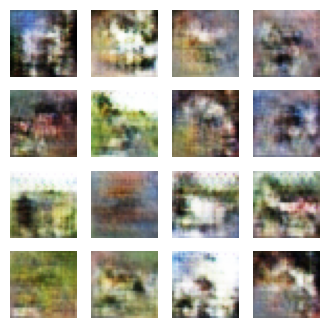

In [29]:
# Restore the latest checkpoint (if needed)
# This can be used to resume training or generate images from a saved model
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

# Function to display a single image generated after a specific epoch
def display_image(epoch_no):
    return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

# Display the image generated after the final epoch
display_image(EPOCHS)

In [30]:
# Save the trained generator model in Keras H5 format
generator.save('generator_model_final.keras')
print("Generator model saved to 'generator_model.h5'")

Generator model saved to 'generator_model.h5'


###**GIF of generated images in each epoch**

In [31]:
# Create an animated GIF of the generated images over epochs
anim_file = 'gan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    # Get the list of image files generated during training
    filenames = glob.glob('image_at_epoch_*.png')
    filenames = sorted(filenames)
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)
    # Append the last image multiple times for a pause at the end
    for _ in range(10):
        writer.append_data(image)

<ipython-input-31-283ca4287b8c>:9: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)


###**Load the saved generator model and generate image**

Generator model loaded successfully.


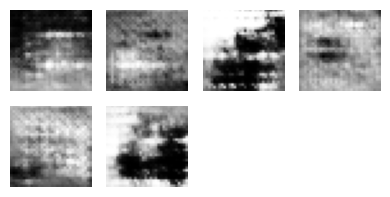

In [32]:
# Import necessary libraries
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# Load the saved generator model
generator_trained = tf.keras.models.load_model('generator_model_final.keras')
print("Generator model loaded successfully.")

# Function to generate and display images
def generate_images(generator, num_images=6, noise_dim=100):
    # Generate random noise vectors
    noise = tf.random.normal([num_images, noise_dim])

    # Generate images using the loaded generator
    generated_images = generator(noise, training=False)

    # Rescale images from [-1, 1] to [0, 1] for display
    generated_images = (generated_images + 1) / 2.0

    # Plot the generated images
    plt.figure(figsize=(4, 4))
    for i in range(num_images):
        plt.subplot(4, 4, i + 1)
        plt.imshow(generated_images[i, :, :, 0], cmap='gray')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Generate and display images
generate_images(generator_trained)

###**Load checkpoint and Start trainig from wher it ended in last**

In [33]:
from tensorflow.keras.models import load_model

# Load the saved generator model
generator = load_model('generator_model_final.keras')

In [ ]:
# Training function to run the training loop
def train(dataset, epochs, start=0):
    for epoch in range(start, start+epochs):
        start = time.time()

        # Iterate over each batch of images
        for image_batch in dataset:
            train_step(image_batch)

        # Clear the output to display progress
        # display.clear_output(wait=True)
        # Generate and save images to visualize progress
        generate_and_save_images(generator, epoch + 1, seed)

        # Save the model every 15 epochs
        if (epoch + 1) % 15 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

        print('Time for epoch {} is {:.2f} sec'.format(epoch + 1, time.time() - start))

    # Generate images after the final epoch
    # display.clear_output(wait=True)
    generate_and_save_images(generator, epochs, seed)
    generator.save('generator_model_final.keras')
    print("Generator model saved to 'generator_model.h5'")

EPOCHS = 100
# Start training the GAN
train(train_dataset, EPOCHS, start=100)

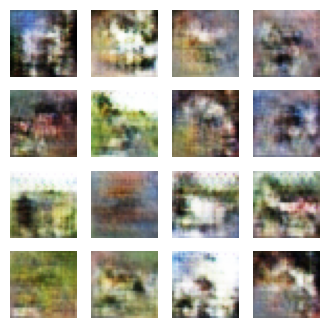

In [36]:
# Restore the latest checkpoint (if needed)
# This can be used to resume training or generate images from a saved model
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

# Function to display a single image generated after a specific epoch
def display_image(epoch_no):
    return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

# Display the image generated after the final epoch
display_image(100)

In [37]:
# Create an animated GIF of the generated images over epochs
anim_file = 'gan200.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    # Get the list of image files generated during training
    filenames = glob.glob('image_at_epoch_*.png')
    filenames = sorted(filenames)
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)
    # Append the last image multiple times for a pause at the end
    for _ in range(10):
        writer.append_data(image)

<ipython-input-37-53ed8603d514>:9: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)
